In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
font = {'family' : 'serif',
#        'weight' : 'bold',
        'size'   : 16,}
matplotlib.rc('font', **font)

from astropy.io import fits
import os
import time
from tqdm import tqdm
import yaml
import scipy
from scipy.special import erf
import scipy.stats as stats
import scipy.signal as signal
from scipy.optimize import curve_fit,minimize
import h5py
from datetime import datetime,timedelta
import corner
import importlib

import fit_time_dep_fluxes as fit_flux
# from importlib import reload
# reload(fit_flux)




In [152]:
tele = 'apo'
ftype = 'object' 

expid = "0065" 
chip = "R"
mjd = 60781

# expid = "0041"
# chip = "R"
# mjd = 60786

# ftype = 'quartzflat'
# expid = "0003"
# chip = "R"
# mjd = 60781


datapath = '/Users/kevinm/Downloads/sdss_raw_fluxes/'

fname_1d = f'{datapath}ar1Dcal_{tele}_{mjd}_{expid}_{chip}_{ftype}.h5'
data_1d = h5py.File(fname_1d)
print(data_1d.keys())

fiber_types = np.array(data_1d['fiberTypeList']).astype(str)
fiber_flux_1ds = np.array(data_1d['flux_1d'])
fiber_med_fluxes = np.nanmedian(fiber_flux_1ds,axis=1)
fiber_trace_centers = np.array(data_1d['extract_trace_centers'])-1 #subtract 1 because indices are from Julia

data_1d.close()

<KeysViewHDF5 ['bitmsk_relthrpt', 'dropped_pixels_mask_1d', 'extract_trace_centers', 'fiberTypeList', 'flux_1d', 'ivar_1d', 'mask_1d', 'metadata', 'relthrpt', 'trace_used_param_fname']>


In [153]:
uniWaveAPOGEE = np.power(10, np.linspace(4.17825,4.17825+6.0e-6*(8700-1),8700))

# fname_1d = f'{datapath}ar1Dunical_{tele}_{mjd}_{expid}_{ftype}.h5'
# data_1d = h5py.File(fname_1d)
# extract_trace_coords = np.array(data_1d['extract_trace_coords'])
# print(data_1d.keys())

# near_pix = (extract_trace_coords[2][54] == 1) & (np.abs(extract_trace_coords[0][54]-1949) < 1) 
# uniWaveAPOGEE[near_pix]

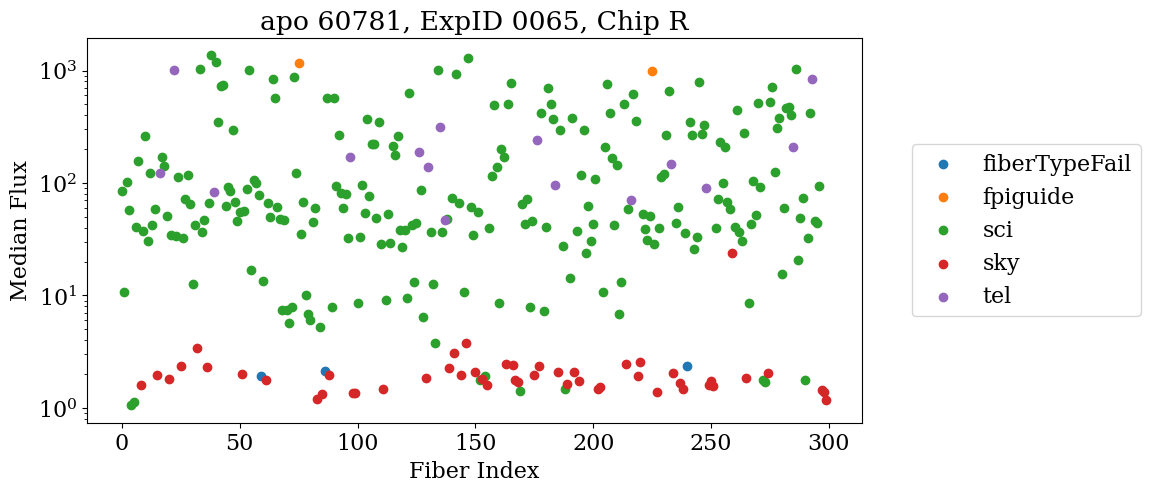

In [154]:
fiber_inds = np.arange(fiber_med_fluxes.shape[0])

unique_fiber_types = np.unique(fiber_types)

plt.figure(figsize=(10,5))
plt.title(f'{tele} {mjd}, ExpID {expid}, Chip {chip}')
for fib_type in unique_fiber_types:
    curr_keep = (fiber_types == fib_type)
    plt.scatter(fiber_inds[curr_keep],fiber_med_fluxes[curr_keep],label=fib_type)
plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
plt.gca().set_yscale('log')
plt.xlabel('Fiber Index')
plt.ylabel('Median Flux')
plt.show()

Current fiber index: 54
Current fiber type: sci
Current fiber median flux: 1009.8


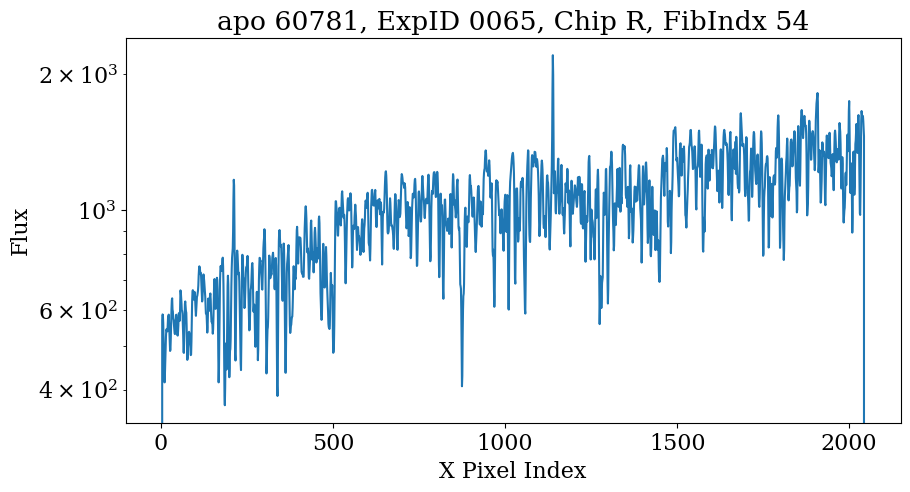

In [155]:
#sort the sci and tel fibers by median flux (decreasing from max)
if ftype == 'object':
    use_types = ((fiber_types == 'sci') | (fiber_types == 'tel'))
else:
    use_types = ((fiber_types == 'cal') | (fiber_types == 'tel'))
good_explore_inds = np.where(use_types)[0][np.argsort(fiber_med_fluxes[use_types])[::-1]]
chosen_fib_ind = good_explore_inds[5]
if ftype == 'object':
    chosen_fib_ind = 54
else:
    chosen_fib_ind = good_explore_inds[10]

fiber_index =  chosen_fib_ind + 1
print(f'Current fiber index: {chosen_fib_ind}')
print(f'Current fiber type: {fiber_types[chosen_fib_ind]}')
print(f'Current fiber median flux: {round(fiber_med_fluxes[chosen_fib_ind],2)}')


x_inds = np.arange(fiber_flux_1ds.shape[1])
plt.figure(figsize=(10,5))
plt.gca().set_yscale('log')
plt.title(f'{tele} {mjd}, ExpID {expid}, Chip {chip}, FibIndx {chosen_fib_ind}')
plt.plot(x_inds,fiber_flux_1ds[chosen_fib_ind])
plt.xlabel('X Pixel Index')
plt.ylabel('Flux')
plt.show()


In [156]:
fname_3d = f'{datapath}ar3Dcal_{tele}_{mjd}_{expid}_{chip}_{ftype}.h5'
data_3d = h5py.File(fname_3d)
print(data_3d.keys())

chosen_trace_inds = np.round(fiber_trace_centers[chosen_fib_ind]).astype(int)

pixel_best_fit_fluxes = np.array(data_3d['dimage'])[chosen_trace_inds,x_inds]
pixel_chisqimage = np.array(data_3d['chisqimage'])[chosen_trace_inds,x_inds]
pixel_gainMat = np.array(data_3d['gainMat'])[chosen_trace_inds,x_inds]
pixel_readVarMat = np.array(data_3d['readVarMat'])[chosen_trace_inds,x_inds]
pixel_raw_data = np.array(data_3d['outdat'])[:,chosen_trace_inds,x_inds]




<KeysViewHDF5 ['CRimage', 'amp_off_vec', 'chisqimage', 'dimage', 'gainMat', 'ivarimage', 'last_unsaturated', 'metadata', 'outdat', 'readVarMat', 'ref_zpt_out', 'sci_zpt_out']>


In [157]:
pixel_raw_data.shape

(33, 2048)

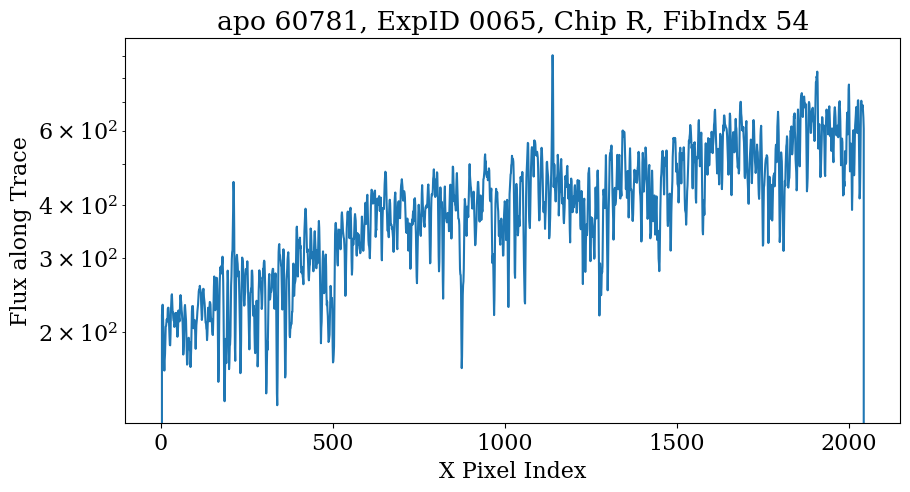

In [158]:
plt.figure(figsize=(10,5))
plt.gca().set_yscale('log')
plt.title(f'{tele} {mjd}, ExpID {expid}, Chip {chip}, FibIndx {chosen_fib_ind}')
plt.plot(x_inds,pixel_best_fit_fluxes)
plt.xlabel('X Pixel Index')
plt.ylabel('Flux along Trace')
plt.show()


In [159]:
data_per_pix = pixel_raw_data.T * pixel_gainMat[:,None] #convert to electrons
read_error_per_pix = np.sqrt(pixel_readVarMat) * pixel_gainMat
n_reads = data_3d['outdat'].shape[0]

In [167]:
use_pixels = np.arange(100-10, 100+10)

use_pixels = np.round(np.linspace(100,2048-100,21)).astype(int)
use_pixels = np.round(np.linspace(100,2048-100,100)).astype(int)+1
# use_pixels = np.round(np.linspace(100,2048-100,200)).astype(int)
# use_pixels = np.round(np.linspace(100,2048-100,200)).astype(int)
# use_pixels = np.round(np.linspace(100,2048-100,1000)).astype(int)

# use_pixels = 1024+np.arange(-50,50)

n_pixels = len(use_pixels)
data_cube = data_per_pix[use_pixels]

count_diffs = np.diff(data_cube,axis=1)


In [168]:
n_pixels

100

In [169]:
obs_fluxes = np.copy(data_cube)
read_errs = read_error_per_pix[use_pixels]

max_b_ind,b_vect_mean,b_vect_Vinv,b_vect_V,\
        f_max_means_given_b,f_max_ivars_given_b,\
        comb_param_means,comb_param_Vinv,comb_param_V = fit_flux.measure_time_dep_fluxes_LINEAR(obs_fluxes,read_errs,
                                                       n_max_repeat=100,b_vect_change_tol=1e-10,
                                                       min_b_val=1e-10,min_f_val=1e-10)

f_means_no_b,f_ivars_no_b,chi2s_data_no_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                           n_repeat=2,b_vect=None)
f_means_with_b,f_ivars_with_b,chi2s_data_with_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                           n_repeat=2,b_vect=b_vect_mean)

non_max_inds = np.ones(len(b_vect_mean)).astype(bool)
non_max_inds[max_b_ind] = False
non_max_inds = np.where(non_max_inds)[0]

b_vect_errs = np.sqrt(np.diag(b_vect_V))
f_max_errs_given_b = np.power(f_max_ivars_given_b,-0.5)

b_vect_mean_linear = np.copy(b_vect_mean)
b_vect_errs_linear = np.copy(b_vect_errs)
b_vect_cov_linear = np.copy(b_vect_V)
f_max_means = comb_param_means[:n_pixels]

Expect:	 [23.24774086 30.33594246 38.73950404]

With b:	 [22.21012077 29.34623654 38.23949542]
	Error inflate 0.99

No b:  	 [101.84728178 153.76108035 219.27954802]
	Error inflate 2.27


/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_45853/178286028.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_45853/178286028.py:123: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


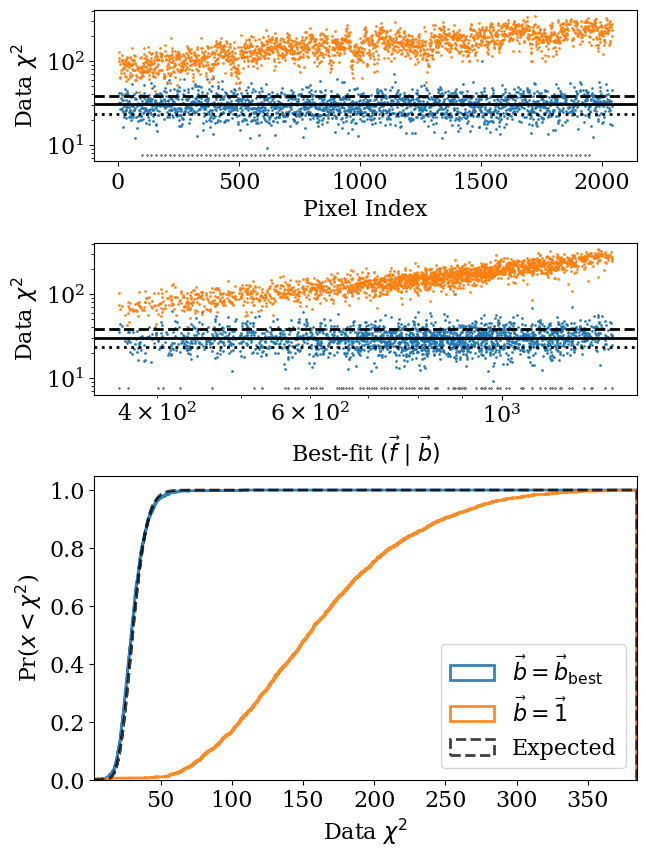

In [170]:
f_means_no_b,f_ivars_no_b,chi2s_data_no_b = fit_flux.fit_fluxes_optimal(data_per_pix,read_error_per_pix,
                                                                           n_repeat=2,b_vect=None)
f_means_with_b,f_ivars_with_b,chi2s_data_with_b = fit_flux.fit_fluxes_optimal(data_per_pix,read_error_per_pix,
                                                                           n_repeat=2,b_vect=b_vect_mean)

lw = 2
alpha = 1.0
cumulative = True

df = n_reads-2

data_chi2_per_df = chi2s_data_with_b/df


percentiles = np.array([16,50,84])
percentiles_ls = [':','-','--']
expect_vals = stats.chi2(loc=0,scale=1,df=df).ppf(percentiles/100)

keep_flux = (f_means_with_b > np.nanpercentile(f_means_with_b,2.5)) & (f_means_with_b < np.nanpercentile(f_means_with_b,97.5))
# keep_flux = (f_means_with_b > np.nanpercentile(f_means_with_b,0.5)) & (f_means_with_b < np.nanpercentile(f_means_with_b,99.5))
keep_flux[use_pixels] = True

print('Expect:\t',expect_vals)
print()
print('With b:\t',np.nanpercentile(chi2s_data_with_b[keep_flux],percentiles))
print('\tError inflate %.2f'%(stats.chi2.fit(chi2s_data_with_b[keep_flux],fdf=df,floc=0)[2]**0.5))
print()
print('No b:  \t',np.nanpercentile(chi2s_data_no_b[keep_flux],percentiles))
print('\tError inflate %.2f'%(stats.chi2.fit(chi2s_data_no_b[keep_flux],fdf=df,floc=0)[2]**0.5))

s = 1
alpha = 0.9

# plt.figure(figsize=(5,3))
fig = plt.figure(figsize=(7, 10), 
                 constrained_layout=True)  # use constrained_layout instead
gs = gridspec.GridSpec(3, 1, hspace=0.4, height_ratios=[1,1,2],
                       figure=fig)  # +1 for Z-scores

ax = fig.add_subplot(gs[0])

# ax = plt.gca()
ax.set_yscale('log')
plt.scatter(x_inds[keep_flux],chi2s_data_with_b[keep_flux],
            s=s,alpha=alpha,
            label=r'$\vec b = \vec b_{\mathrm{best}}$')
plt.scatter(x_inds[keep_flux],chi2s_data_no_b[keep_flux],
            s=s,alpha=alpha,
            label=r'$\vec b = \vec 1$')
for j in range(len(percentiles)):
    plt.axhline(expect_vals[j],c='k',ls=percentiles_ls[j],lw=2)
ylim = ax.get_ylim()
xlim = ax.get_xlim()
for pix_x in use_pixels:
    # plt.axvline(pix_x,c='grey',lw=1,ls='-')
    plt.scatter(pix_x,ylim[0],color='grey',marker='x',s=1)
    # plt.scatter(x_inds[pix_x],chi2s_data_with_b[pix_x],
    #             s=s*10,alpha=alpha,color='C0')
ax.set_xlim(xlim)

plt.ylabel(r'Data $\chi^2$')
plt.xlabel(r'Pixel Index')
ylim = np.array(ax.get_ylim())
# ylim[0] = max(ylim[0],)
# ax.set_ylim(ylim)
# plt.show()


# plt.figure(figsize=(5,3))
# ax = plt.gca()
ax = fig.add_subplot(gs[1])

ax.set_xscale('log')
ax.set_yscale('log')
plt.scatter(f_means_with_b[keep_flux],chi2s_data_with_b[keep_flux],
            s=s,alpha=alpha,
            label=r'$\vec b = \vec b_{\mathrm{best}}$')
plt.scatter(f_means_with_b[keep_flux],chi2s_data_no_b[keep_flux],
            s=s,alpha=alpha,
            label=r'$\vec b = \vec 1$')
for j in range(len(percentiles)):
    plt.axhline(expect_vals[j],c='k',ls=percentiles_ls[j],lw=2)
ylim = ax.get_ylim()
xlim = ax.get_xlim()
for pix_x in use_pixels:
    # plt.axvline(f_means_with_b[pix_x],c='grey',lw=1,ls='-')
    plt.scatter(f_means_with_b[pix_x],ylim[0],color='grey',marker='x',s=1)
ax.set_xlim(xlim)

# plt.axhline(c='k',lw='--')
plt.ylabel(r'Data $\chi^2$')
plt.xlabel(r'Best-fit $(\vec f \mid \vec b)$')
# plt.show()


ax = fig.add_subplot(gs[2])

hist_range = [min(np.min(chi2s_data_with_b),np.min(chi2s_data_no_b)),\
              max(np.max(chi2s_data_with_b),np.max(chi2s_data_no_b))]

hist = plt.hist(chi2s_data_with_b,
         histtype='step',cumulative=cumulative,
         density=True,bins=10000,range=hist_range,
         label=r'$\vec b = \vec b_{\mathrm{best}}$',
         lw=lw,alpha=alpha)
hist_bins = hist[1]
hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])

plt.hist(chi2s_data_no_b,
         histtype='step',cumulative=cumulative,
         density=True,bins=10000,range=hist_range,
         label=r'$\vec b = \vec 1$',
         lw=lw,alpha=alpha)
expect_weights = np.diff(stats.chi2(loc=0,scale=1,df=df).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
leg = plt.legend(loc="lower right")
plt.xlim(hist_range[0],hist_range[1])
plt.xlabel('Data $\chi^2$')
plt.ylabel('Pr($x < \chi^2$)')
plt.tight_layout()
plt.savefig(f"figures/chi2_distribution_{tele}_{mjd}_{chip}_{expid}_OBJECT_F{fiber_index:03d}_linear.png") 
plt.show()




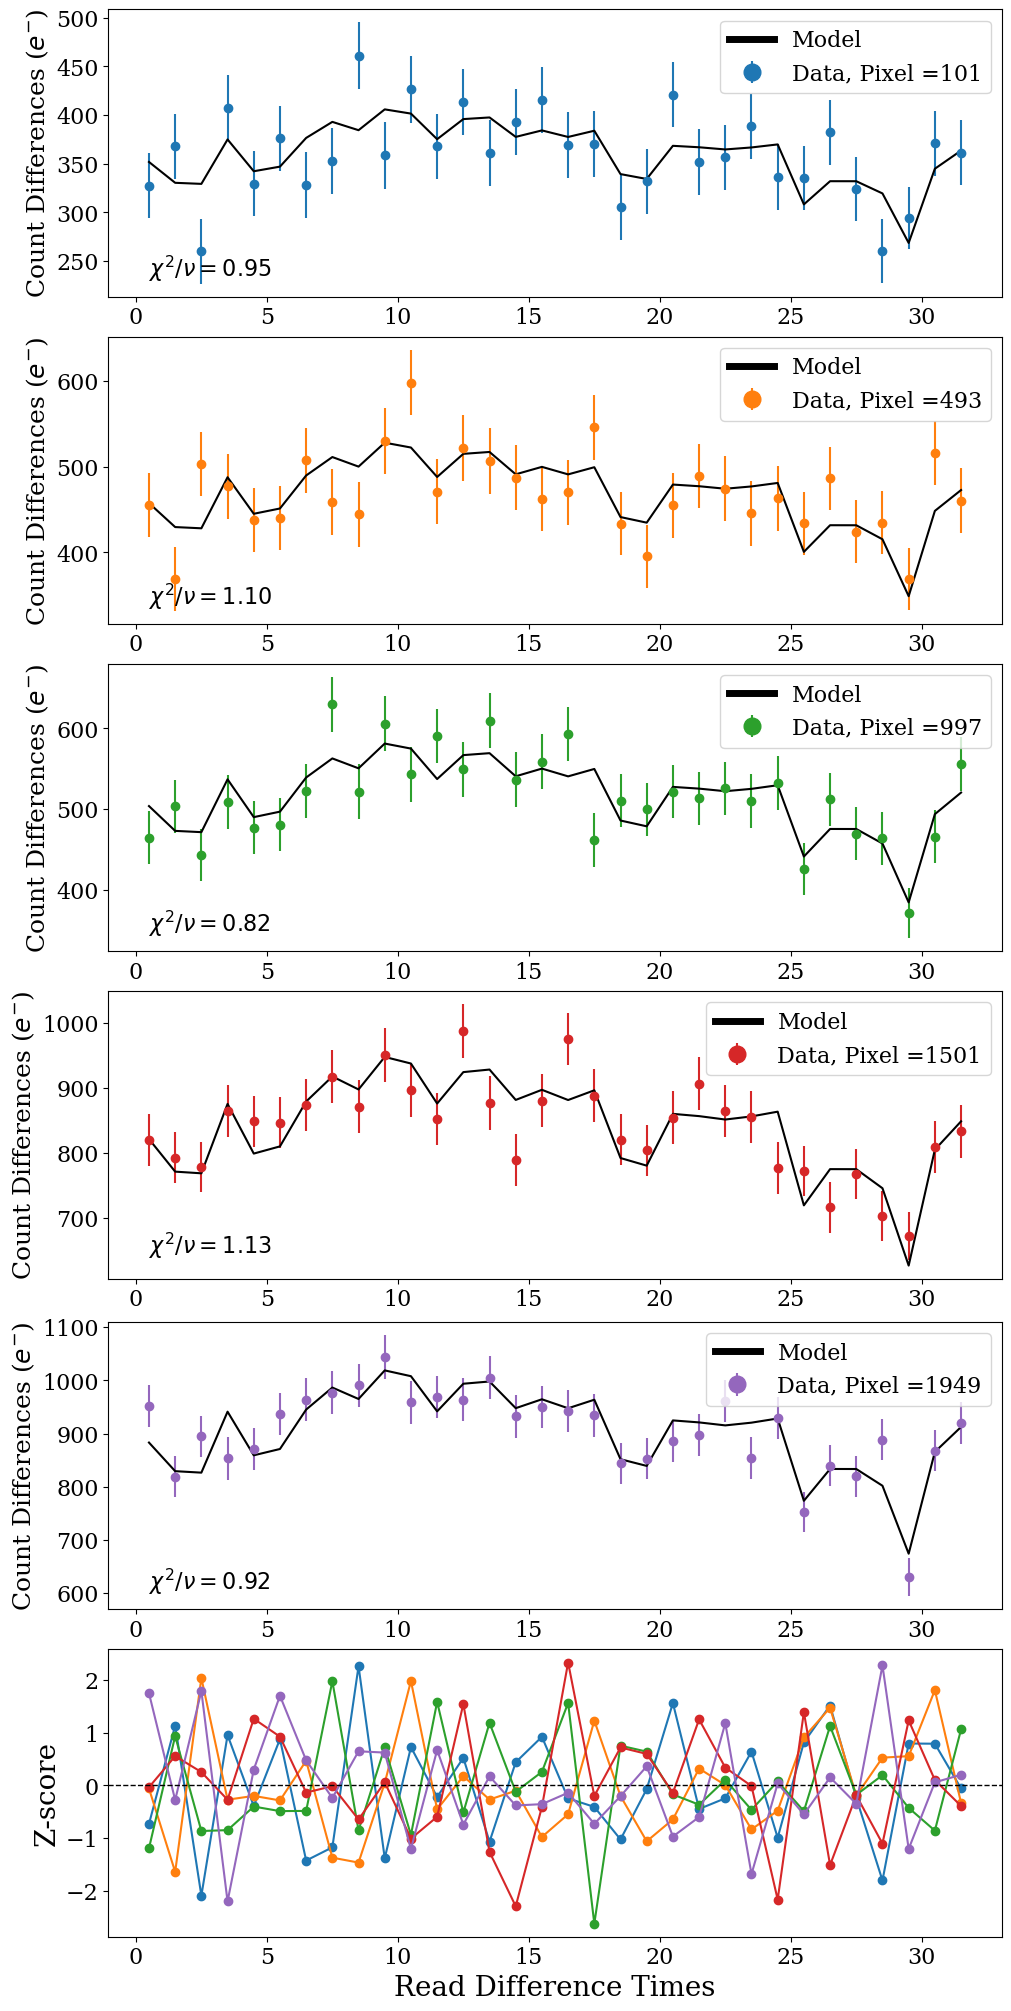

In [171]:
f_max_post = np.copy(f_max_means)
b_vect_post = np.copy(b_vect_mean_linear)
b_vect_post_cov = np.copy(b_vect_cov_linear)
curr_f_post_guess = f_max_post[:, None] * b_vect_post[None, :]
read_times = np.arange(n_reads)
obs_flux_diffs = np.diff(obs_fluxes,axis=1)
read_vars = np.power(read_errs,2)

read_Vs = np.zeros((n_pixels,n_reads-1,n_reads-1))
data_V = np.zeros((n_pixels,n_reads-1,n_reads-1))
curr_data_diffs = np.maximum(curr_f_post_guess,0)
for p_ind in range(n_pixels):
    read_Vs[p_ind,np.arange(n_reads-1),np.arange(n_reads-1)] = 2*read_vars[p_ind]
    for j in range(len(read_Vs[p_ind])-1):
        read_Vs[p_ind,j,j+1] = -read_vars[p_ind]
        read_Vs[p_ind,j+1,j] = -read_vars[p_ind]
            
for p_ind in range(n_pixels):
    data_V[p_ind] = np.diag(curr_data_diffs[p_ind])



fibers = [0, 4, 10, 15, 20]
desired_pix_nums = [100,500,1000,1500,2000]
fibers = np.zeros(len(desired_pix_nums)).astype(int)
for j in range(len(desired_pix_nums)):
    fibers[j] = np.argmin(np.abs(desired_pix_nums[j]-use_pixels))
    
colors = plt.cm.tab10(np.linspace(0, 1, len(fibers)))

# ----------------------------
# Combined figure with subplots
# ----------------------------
fig = plt.figure(figsize=(10, 20), constrained_layout=True)  # use constrained_layout instead
gs = gridspec.GridSpec(len(fibers)+1, 1, figure=fig)  # +1 for Z-scores

# ax = fig.add_subplot(gs[0])
# ax.errorbar(
#     read_times[:-1]+0.5,
#     b_vect_post,
#     yerr=np.sqrt(np.diag(b_vect_post_cov)),
#     fmt="-o",
#     color="black",
# )
# ax.axhline(1.0,color='grey',ls='--')

# ax.set_ylabel("Flux Multiplication\n Factor")

# ---- Count Difference subplots ----
for idx, j in enumerate(fibers):
    ax = fig.add_subplot(gs[idx])
    color = f"C{idx}"

    ax.errorbar(
        read_times[:-1]+0.5,
        obs_flux_diffs[j],
        yerr=np.sqrt(np.diag(data_V[j]+read_Vs[j])),
        fmt="o",
        color=color,
        label=f"Data, Pixel ={use_pixels[j]}",
    )
    ax.plot(
        read_times[:-1]+0.5,
        curr_f_post_guess[j],
        linestyle="-",
        color="black",
        label="Model"
    )
    min_val = (obs_flux_diffs[j]-np.sqrt(np.diag(data_V[j]+read_Vs[j]))).min()
    ax.text(0.5,min_val,r'$\chi^2/\nu = %.2f$'%(data_chi2_per_df[use_pixels[j]]),va='bottom',ha='left')
    ax.set_ylabel(r"Count Differences ($e^{-}$)",fontsize=18)
    leg = ax.legend(loc=1,markerscale=2)
    for line in leg.get_lines():
        line.set_linewidth(5)

# ---- Combined Z-scores subplot ----
ax = fig.add_subplot(gs[-1])
for idx, j in enumerate(fibers):
    color = f"C{idx}"
    sigma = np.sqrt(np.diag(data_V[j]+read_Vs[j]))
    z_score = (obs_flux_diffs[j] - curr_f_post_guess[j]) / sigma

    ax.plot(
        read_times[:-1]+0.5,
        z_score,
        "-o",
        color=color
    )

ax.axhline(0, color="black", linestyle="--", linewidth=1)
ax.set_xlabel("Read Difference Times",fontsize=20)
ax.set_ylabel("Z-score",fontsize=20)

# ---- Save one big PNG ----
if ftype == 'object':

    plt.savefig("combined_all_fibers_linear.png", dpi=300, bbox_inches="tight")
else:
    plt.savefig("combined_all_fibers_calibration_linear.png", dpi=300, bbox_inches="tight")
plt.show()


In [134]:
# x_bins = np.arange(x_inds[0]-0.5,x_inds[-1]+0.5+1e-10,1)

# plt.hist2d()
# plt.show()

In [135]:
if ftype != 'object':
    plot_b_vect_post = np.copy(b_vect_mean_linear)
    plot_b_vect_post_cov = np.copy(b_vect_cov_linear)
    
    bad_inds = np.where(~np.isfinite(np.diag(plot_b_vect_post_cov)))[0]
    non_max_inds = np.ones(len(plot_b_vect_post)).astype(bool)
    non_max_inds[bad_inds] = False
    non_max_inds = np.where(non_max_inds)[0]
    
    plot_b_vect_post_inv_cov = np.linalg.inv(plot_b_vect_post_cov[non_max_inds][:,non_max_inds])
    comp_b = plot_b_vect_post[non_max_inds]
    mult_var = 1/np.dot(np.dot(comp_b,plot_b_vect_post_inv_cov),comp_b)
    mult_mean = 1/(mult_var * np.dot(np.dot(comp_b,plot_b_vect_post_inv_cov),np.ones(len(non_max_inds))))
    
    plot_b_vect_post /= mult_mean
    plot_b_vect_post_cov /= mult_mean**2
    plot_b_vect_post_inv_cov *= mult_mean**2
    
    comp_b = plot_b_vect_post[non_max_inds]
    # chi2_score = np.sum(np.power(comp_b-1,2)/(np.diag(plot_b_vect_post_cov[non_max_inds][:,non_max_inds])))/(n_reads-2)
    chi2_score = np.dot(np.dot(comp_b-1,plot_b_vect_post_inv_cov),comp_b-1)/(n_reads-2)
    
    # ----------------------------
    # Combined figure with subplots
    # ----------------------------
    fig = plt.figure(figsize=(10, 20/6*2), constrained_layout=True)  # use constrained_layout instead
    gs = gridspec.GridSpec(2, 1, figure=fig)  # +1 for Z-scores
    
    ax = fig.add_subplot(gs[0])
    ax.errorbar(
        read_times[:-1]+0.5,
        plot_b_vect_post,
        yerr=np.sqrt(np.diag(plot_b_vect_post_cov)),
        fmt="-o",
        color="C0",
    )
    ax.errorbar(
        (read_times[:-1]+0.5)[bad_inds],
        plot_b_vect_post[bad_inds],
        yerr=np.sqrt(np.diag(plot_b_vect_post_cov[bad_inds,bad_inds])),
        fmt="o",
        color="r",
    )
    
    ax.axhline(1.0,c='k',lw=1,ls='--')
    
    ax.set_ylabel("Flux Multiplication\n Factor",fontsize=20)
    
    # ---- Combined Z-scores subplot ----
    ax = fig.add_subplot(gs[-1])
    
    ax.plot(
        read_times[:-1]+0.5,
        (plot_b_vect_post-1)/np.sqrt(np.diag(plot_b_vect_post_cov)),
        "-o",
        color='C0'
    )
    ax.plot(
        (read_times[:-1]+0.5)[bad_inds],
        ((plot_b_vect_post-1)/np.sqrt(np.diag(plot_b_vect_post_cov)))[bad_inds],
        "o",
        color='r'
    )
    ax.text(np.mean(read_times[:-1]+0.5),
            np.nanmin((plot_b_vect_post-1)/np.sqrt(np.diag(plot_b_vect_post_cov))),
            r'$\frac{\chi^2}{\nu} = %.3f$'%chi2_score,
        ha='center',va='bottom',fontsize=20)
    
    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.set_xlabel("Read Difference Times",fontsize=20)
    ax.set_ylabel("Z-score",fontsize=20)
    
    # ---- Save one big PNG ----
    plt.savefig("calibration_linear_b_vect.png", dpi=300, bbox_inches="tight")
    plt.show()


In [136]:
# all_count_diffs = np.diff(data_per_pix, axis = 1)
# all_count_diffs_cor = all_count_diffs/b_vect_post


# C = fitramp.Covar(read_times)


# debias = True

# result = fitramp.fit_ramps(all_count_diffs.T, C, read_error_per_pix)
# result_cor = fitramp.fit_ramps(all_count_diffs_cor.T, C, read_error_per_pix, flux_rescalings=b_vect_post)

# if debias:
#     countrateguess = result.countrate*(result.countrate > 0)
#     countrateguess_cor = result_cor.countrate*(result_cor.countrate > 0)
    
#     result = fitramp.fit_ramps(all_count_diffs.T, C, read_error_per_pix,
#                                countrateguess=countrateguess)
    
#     result_cor = fitramp.fit_ramps(all_count_diffs_cor.T, C, read_error_per_pix,flux_rescalings=b_vect_post,
#                                countrateguess=countrateguess_cor)
  

#         # The count rates, chi squared values, and uncertainties for this row are:
#         # result.countrate
#         # result.chisq
#         # result.uncert
#         #
#         # You can save these to another structure if you want, or you can 
#         # reorganize the structure for result used here.

#         # Note: if we want the weights, they are available, as follows.

#         # Weights on the scaled resultant differences:

#         #weights_differences = result.weights

#         # Or the equivalent weights on the resultants themselves:

#         #weights_resultants = np.zeros(d[:, i].shape)
#         #weights_resultants[1:] = result.weights/C.delta_t[:, np.newaxis]
#         #weights_resultants[:-1] -= result.weights/C.delta_t[:, np.newaxis]




Plotting data for apo, MJD 60781, chip R, ExpID 0065, fibInd 54, pixel index 1949


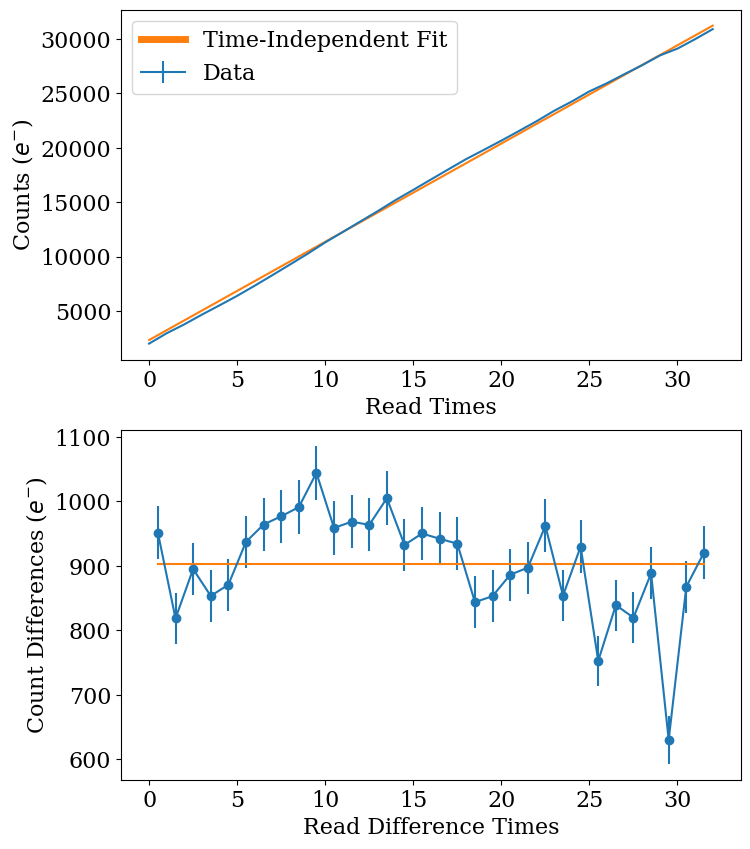

In [137]:
if ftype == 'object':
    fig = plt.figure(figsize=(8, 10))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.2)
    
    j = 20
    j = 21
    j = np.argmin(np.abs(use_pixels-2000))
    print(f'Plotting data for {tele}, MJD {mjd}, chip {chip}, ExpID {expid}, fibInd {chosen_fib_ind}, pixel index {use_pixels[j]}')
    
    offset = np.median(data_cube[j] - np.cumsum(np.ones(n_reads) * f_means_no_b[use_pixels[j]]))
    # -------------------------
    # First subplot (Counts vs Read Times)
    # -------------------------
    ax1 = fig.add_subplot(gs[0])
    
    ax1.errorbar(
        read_times,
        data_cube[j],
        yerr= read_error_per_pix[j],
        label="Data"
    )
    ax1.plot(
        read_times,
        np.cumsum(np.ones(n_reads) * f_means_no_b[use_pixels[j]]) + offset,
        label="Time-Independent Fit"
    )
    
    ax1.set_ylabel(r"Counts ($e^{-}$)")
    ax1.set_xlabel(r"Read Times")
    leg = ax1.legend()
    for line in leg.get_lines():
        line.set_linewidth(5)
    xlim = ax1.get_xlim()
    
    
    # -------------------------
    # Second subplot (Count Differences vs Read Times)
    # -------------------------
    ax2 = fig.add_subplot(gs[1])
    
    ax2.errorbar(
        read_times[:-1] + 0.5,
        count_diffs[j],
        yerr=np.sqrt(2 * read_error_per_pix[j]**2+count_diffs[j]),
        label="Data",fmt="-o"
    )
    ax2.plot(
        read_times[:-1] + 0.5,
        np.ones(n_reads - 1) * f_means_no_b[use_pixels[j]],
        label="Time-Independent Fit"
    )
    
    ax2.set_ylabel(r"Count Differences ($e^{-}$)")
    ax2.set_xlabel("Read Difference Times")
    # ax2.legend()
    ax2.set_xlim(xlim)
    
    
    # -------------------------
    # Save + Show
    # -------------------------
    plt.savefig("combined_counts_real_linear.png", dpi=300, bbox_inches="tight")
    plt.show()


<KeysViewHDF5 ['bitmsk_relthrpt', 'dropped_pixels_mask_1d', 'extract_trace_centers', 'fiberTypeList', 'flux_1d', 'ivar_1d', 'mask_1d', 'metadata', 'relthrpt', 'trace_used_param_fname']>
<KeysViewHDF5 ['bitmsk_relthrpt', 'dropped_pixels_mask_1d', 'extract_trace_centers', 'fiberTypeList', 'flux_1d', 'ivar_1d', 'mask_1d', 'metadata', 'relthrpt', 'trace_used_param_fname']>
<KeysViewHDF5 ['bitmsk_relthrpt', 'dropped_pixels_mask_1d', 'extract_trace_centers', 'fiberTypeList', 'flux_1d', 'ivar_1d', 'mask_1d', 'metadata', 'relthrpt', 'trace_used_param_fname']>


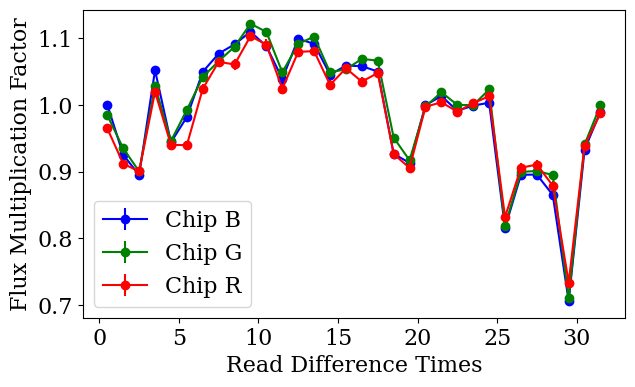

In [88]:


b_vector_chip = {}
b_vector_error_chip = {}
b_vector_cov_chip = {}

first = True
for l, q, chip_ind in zip(["a", "b", "c"], ["R", "G", "B"], [0,1,2]):
    
    tele = 'apo'
    ftype = 'object' #object 

    expid = "0065" #0065
    chip = q
    mjd = 60781

    # expid = "0041"
    # chip = "R"
    # mjd = 60786

    fname_1d = f'{datapath}ar1Dcal_{tele}_{mjd}_{expid}_{chip}_{ftype}.h5'
    data_1d = h5py.File(fname_1d)
    print(data_1d.keys())

    fiber_types = np.array(data_1d['fiberTypeList']).astype(str)
    fiber_flux_1ds = np.array(data_1d['flux_1d'])
    fiber_med_fluxes = np.nanmedian(fiber_flux_1ds,axis=1)
    fiber_trace_centers = np.array(data_1d['extract_trace_centers'])-1 #subtract 1 because indices are from Julia

    data_1d.close()
    
    chosen_fib_ind = 54  #283
    fiber_index =  chosen_fib_ind + 1
    x_inds = np.arange(fiber_flux_1ds.shape[1])
    
    fname_3d = f'{datapath}ar3Dcal_{tele}_{mjd}_{expid}_{chip}_{ftype}.h5'
    data_3d = h5py.File(fname_3d)

    chosen_trace_inds = np.round(fiber_trace_centers[chosen_fib_ind]).astype(int)

    pixel_best_fit_fluxes = np.array(data_3d['dimage'])[chosen_trace_inds,x_inds]
    pixel_chisqimage = np.array(data_3d['chisqimage'])[chosen_trace_inds,x_inds]
    pixel_gainMat = np.array(data_3d['gainMat'])[chosen_trace_inds,x_inds]
    pixel_readVarMat = np.array(data_3d['readVarMat'])[chosen_trace_inds,x_inds]
    pixel_raw_data = np.array(data_3d['outdat'])[:,chosen_trace_inds,x_inds]

    data_per_pix = pixel_raw_data.T * pixel_gainMat[:,None] #convert to electrons
    read_error_per_pix = np.sqrt(pixel_readVarMat)* pixel_gainMat
    n_reads = data_3d['outdat'].shape[0]

    count_diff = np.diff(data_per_pix,axis=1)


    use_pixels = np.arange(100-10, 100+10)

    use_pixels = np.round(np.linspace(100,2048-100,21)).astype(int)
    use_pixels = np.round(np.linspace(100,2048-100,101)).astype(int)

    n_pixels = len(use_pixels)
    data_cube = data_per_pix[use_pixels]

    count_diffs = np.diff(data_cube,axis=1)

    obs_fluxes = np.copy(data_cube)
    read_errs = read_error_per_pix[use_pixels]

    max_b_ind,b_vect_mean,b_vect_Vinv,b_vect_V,\
            f_max_means_given_b,f_max_ivars_given_b,\
            comb_param_means,comb_param_Vinv,comb_param_V = fit_flux.measure_time_dep_fluxes_LINEAR(obs_fluxes,read_errs,
                                                           n_max_repeat=1000,b_vect_change_tol=1e-10,
                                                           min_b_val=1e-10,min_f_val=1e-10)

    f_means_no_b,f_ivars_no_b,chi2s_data_no_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                               n_repeat=2,b_vect=None)
    f_means_with_b,f_ivars_with_b,chi2s_data_with_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                               n_repeat=2,b_vect=b_vect_mean)

    non_max_inds = np.ones(len(b_vect_mean)).astype(bool)
    non_max_inds[max_b_ind] = False
    non_max_inds = np.where(non_max_inds)[0]

    b_vect_errs = np.sqrt(np.diag(b_vect_V))
    f_max_errs_given_b = np.power(f_max_ivars_given_b,-0.5)

    b_vect_mean_linear = np.copy(b_vect_mean)
    b_vect_errs_linear = np.copy(b_vect_errs)
    b_vect_cov_linear = np.copy(b_vect_V)
    f_max_means = comb_param_means[:n_pixels]



    f_max_post = np.copy(f_max_means)
    b_vect_post = np.copy(b_vect_mean_linear)
    b_vect_post_cov = np.copy(b_vect_cov_linear)
    curr_f_post_guess = f_max_post[:, None] * b_vect_post[None, :]
    read_times = np.arange(n_reads)
    obs_flux_diffs = np.diff(obs_fluxes,axis=1)
    read_vars = np.power(read_errs,2)

    read_Vs = np.zeros((n_pixels,n_reads-1,n_reads-1))
    data_V = np.zeros((n_pixels,n_reads-1,n_reads-1))
    curr_data_diffs = np.maximum(curr_f_post_guess,0)


    all_count_diffs = np.diff(data_per_pix, axis = 1)
    all_count_diffs_cor = all_count_diffs/b_vect_post

    if first:
        b_inv_covs = np.zeros((3,len(b_vect_post),len(b_vect_post)))
        b_covs = np.zeros((3,len(b_vect_post),len(b_vect_post)))
        b_means = np.zeros((3,len(b_vect_post)))
        first = False

    b_scale = np.nanmedian(b_vect_post)
    b_scale = 1.0
    b_inv_covs[chip_ind] = b_vect_Vinv * b_scale**2
    b_covs[chip_ind] = b_vect_post_cov / b_scale**2
    b_means[chip_ind] = b_vect_post / b_scale
    
    # C = fitramp.Covar(read_times)


    # debias = True

    # result = fitramp.fit_ramps(all_count_diffs.T, C, read_error_per_pix)
    # result_cor = fitramp.fit_ramps(all_count_diffs_cor.T, C, read_error_per_pix, flux_rescalings=b_vect_post)

    # if debias:
    #     countrateguess = result.countrate*(result.countrate > 0)
    #     countrateguess_cor = result_cor.countrate*(result_cor.countrate > 0)

    #     result = fitramp.fit_ramps(all_count_diffs.T, C, read_error_per_pix,
    #                                countrateguess=countrateguess)

    #     result_cor = fitramp.fit_ramps(all_count_diffs_cor.T, C, read_error_per_pix,flux_rescalings=b_vect_post,
    #                                countrateguess=countrateguess_cor)


    #         # The count rates, chi squared values, and uncertainties for this row are:
    #         # result.countrate
    #         # result.chisq
    #         # result.uncert
    #         #
    #         # You can save these to another structure if you want, or you can 
    #         # reorganize the structure for result used here.

    #         # Note: if we want the weights, they are available, as follows.

    #         # Weights on the scaled resultant differences:

    #         #weights_differences = result.weights

    #         # Or the equivalent weights on the resultants themselves:

    #         #weights_resultants = np.zeros(d[:, i].shape)
    #         #weights_resultants[1:] = result.weights/C.delta_t[:, np.newaxis]
    #         #weights_resultants[:-1] -= result.weights/C.delta_t[:, np.newaxis]

    b_vector_chip[q] = b_vect_post/np.nanmedian(b_vect_post)
    b_vector_error_chip[q] = np.sqrt(np.diag(b_vect_post_cov/np.nanmedian(b_vect_post)))


plt.figure(figsize=(7, 4))
plt.errorbar(read_times[:-1]+0.5,b_vector_chip["B"],yerr = b_vector_error_chip["B"], fmt = "-o", label = "Chip B", color="blue")
plt.errorbar(read_times[:-1]+0.5,b_vector_chip["G"],yerr = b_vector_error_chip["G"], fmt = "-o", label = "Chip G",color="green")
plt.errorbar(read_times[:-1]+0.5,b_vector_chip["R"],yerr = b_vector_error_chip["R"], fmt = "-o", label = "Chip R",color="red")

plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication Factor') 
plt.legend()
plt.savefig("all_b_vector_linear.png", dpi=300, bbox_inches='tight')
plt.show()


In [105]:
'''
Measure weighted-average, then find best offset from weighted-average
'''

comp_ind = 0
comp_b_cov = b_covs[comp_ind]
comp_b_mean = b_means[comp_ind]

mult_factors = np.ones(len(b_means))
mult_factor_errs = np.zeros(len(b_means))
for j in range(len(b_means)):
    if j == comp_ind:
        continue
        
    curr_cov = comp_b_cov+b_covs[j]
    curr_diff = comp_b_mean-b_means[j]
    bad_inds = np.where(~np.isfinite(np.diag(curr_cov)))[0]

    keep_inds = np.ones(len(curr_diff)).astype(bool)
    keep_inds[bad_inds] = False
    keep_inds = np.where(keep_inds)[0]

    copy_diff = curr_diff[keep_inds]
    copy_cov = curr_cov[keep_inds][:,keep_inds]

    copy_inv_cov = np.linalg.inv(copy_cov)
    mult_factor_ivar = np.dot(np.dot(b_means[j,keep_inds],copy_inv_cov),b_means[j,keep_inds])
    mult_factor_errs[j] = mult_factor_ivar**-0.5
    mult_factors[j] = np.dot(np.dot(b_means[j,keep_inds],copy_inv_cov),comp_b_mean[keep_inds])/mult_factor_ivar

print(mult_factors)
b_means *= mult_factors[:,None]
b_covs *= np.power(mult_factors,2)[:,None,None]
b_inv_covs /= np.power(mult_factors,2)[:,None,None]

comb_mean_inv_cov = np.sum(b_inv_covs,axis=0)
bad_inds = np.where(np.diag(comb_mean_inv_cov) == 0)[0]
keep_inds = np.ones(len(curr_diff)).astype(bool)
keep_inds[bad_inds] = False
keep_inds = np.where(keep_inds)[0]

comb_mean_cov = np.zeros((len(b_means[0]),len(b_means[0])))
comb_mean_b = np.nanmean(b_means,axis=0)

curr_cov = np.linalg.inv(np.sum(b_inv_covs[:,keep_inds][:,:,keep_inds],axis=0))
curr_mean = np.dot(curr_cov,np.sum(np.einsum('nij,nj->ni',b_inv_covs[:,keep_inds][:,:,keep_inds],b_means[:,keep_inds]),axis=0))
for j,ind in enumerate(keep_inds):
    comb_mean_cov[ind,keep_inds] = curr_cov[j]
comb_mean_b[keep_inds] = curr_mean

diffs = b_means-comb_mean_b
b_means_chi2_per_df = np.einsum('ni,ni->n',diffs,np.einsum('nij,nj->ni',b_inv_covs,diffs))/np.sum(np.diag(b_inv_covs[0]) > 0)

[1.         1.00000721 0.99999219]


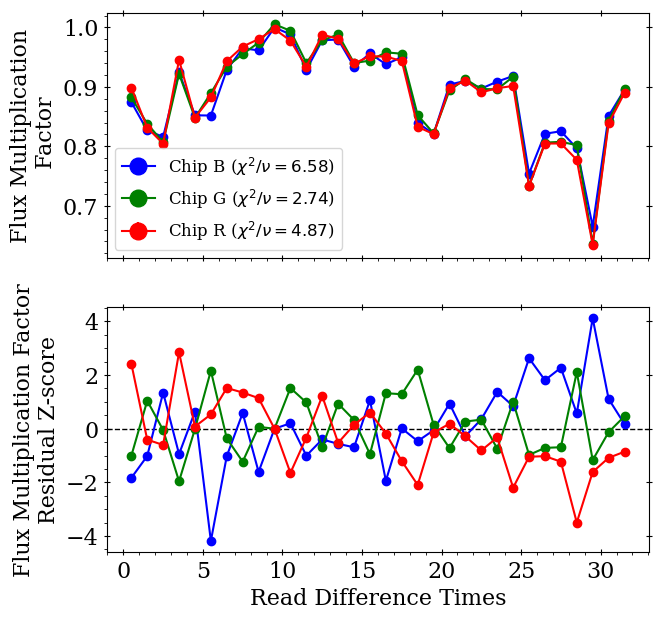

In [113]:
plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(2,1,wspace=0.1)
ax = plt.subplot(gs[0])    
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

plt.errorbar(read_times[:-1]+0.5,b_means[0],yerr = np.sqrt(np.diag(b_covs[0])), fmt = "-o", 
             label = r"Chip B ($\chi^2/\nu = %.2f$)"%(b_means_chi2_per_df[0]), color="blue")
plt.errorbar(read_times[:-1]+0.5,b_means[1],yerr = np.sqrt(np.diag(b_covs[1])), fmt = "-o", 
             label = r"Chip G ($\chi^2/\nu = %.2f$)"%(b_means_chi2_per_df[1]),color="green")
plt.errorbar(read_times[:-1]+0.5,b_means[2],yerr = np.sqrt(np.diag(b_covs[2])), fmt = "-o", 
             label = r"Chip R ($\chi^2/\nu = %.2f$)"%(b_means_chi2_per_df[2]),color="red")
# plt.errorbar(read_times[:-1]+0.5,comb_mean_b,yerr = np.sqrt(np.diag(comb_mean_cov)), fmt = "-o", 
#              label = "Mean",color="black", zorder = -1e10)

# plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication\n Factor') 
ax.set_xticklabels([])
plt.legend(markerscale=2,fontsize=12)
# plt.savefig("all_b_vector_linear.png", dpi=300, bbox_inches='tight')
# plt.show()


# plt.figure(figsize=(7, 4))
ax = plt.subplot(gs[1])    
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

# plt.errorbar(read_times[:-1]+0.5,b_means[0]-comb_mean_b,yerr = np.sqrt(np.diag(b_covs[0])+np.diag(comb_mean_cov)), 
#              fmt = "-o", label = "Chip B", color="blue")
# plt.errorbar(read_times[:-1]+0.5,b_means[1]-comb_mean_b,yerr = np.sqrt(np.diag(b_covs[1])+np.diag(comb_mean_cov)), 
#              fmt = "-o", label = "Chip G",color="green")
# plt.errorbar(read_times[:-1]+0.5,b_means[2]-comb_mean_b,yerr = np.sqrt(np.diag(b_covs[2])+np.diag(comb_mean_cov)), 
#              fmt = "-o", label = "Chip R",color="red")
plt.errorbar(read_times[:-1]+0.5,(b_means[0]-comb_mean_b)/np.sqrt(np.diag(b_covs[0])+np.diag(comb_mean_cov)), 
             fmt = "-o", label = "Chip B", color="blue")
plt.errorbar(read_times[:-1]+0.5,(b_means[1]-comb_mean_b)/np.sqrt(np.diag(b_covs[1])+np.diag(comb_mean_cov)), 
             fmt = "-o", label = "Chip G",color="green")
plt.errorbar(read_times[:-1]+0.5,(b_means[2]-comb_mean_b)/np.sqrt(np.diag(b_covs[2])+np.diag(comb_mean_cov)), 
             fmt = "-o", label = "Chip R",color="red")
plt.axhline(0,c='k',lw=1,ls='--')

plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication Factor\nResidual Z-score') 
# plt.legend()
# plt.savefig("all_b_vector_linear_resids.png", dpi=300, bbox_inches='tight')
plt.savefig("all_b_vector_linear.png", dpi=300, bbox_inches='tight')

plt.show()
